<a href="https://colab.research.google.com/github/jxb5778/AmazonCustomerReviews/blob/master/yelp_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 215.7MB 55kB/s 
     |████████████████████████████████| 204kB 48.5MB/s 


In [0]:
import os
import findspark


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Row, types

from pyspark.ml import Pipeline

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF

from pyspark.ml.clustering import LDA

import matplotlib.pyplot as plt

In [0]:
def start_spark_session():

  findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
  spark = SparkSession.builder.master("local").appName("topic modeling").getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel('ERROR')

  return spark, sc


def build_pipeline(input_col, num_topics):

    tokenizer = RegexTokenizer(inputCol=input_col, outputCol="words")

    stopRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="stop_removed")

    countVectorizer = CountVectorizer(inputCol=stopRemover.getOutputCol(), outputCol="term_freq", minDF=10, maxDF=0.85, vocabSize=50000) 

    idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="features")

    lda = LDA(k=num_topics, maxIter=10)

    pipeline = Pipeline(stages=[tokenizer, stopRemover, countVectorizer, idf, lda])

    return pipeline


def run_model_evaluation(num_topic_list, data, input_col):

    grid_search_results = dict()
    best_perplexity = None
    best_k = 0

    for num_topics in num_topic_list:

      print("Fitting pipeline, num topics: ", num_topics)
      test_pipeline = build_pipeline(input_col, num_topics)
      test_model = test_pipeline.fit(data)

      print("Transforming data...")
      test_transform = test_model.transform(data)
      test_transform.cache()

      test_perplexity = test_model.stages[-1].logPerplexity(test_transform)
      grid_search_results[num_topics] = test_perplexity

      if best_perplexity is None:
        best_perplexity = test_perplexity
        best_k = num_topics

      elif test_perplexity < best_perplexity:
        best_perplexity = test_perplexity
        best_k = num_topics

    best_model = build_pipeline(input_col, best_k)

    return best_model, grid_search_results


def display_topics(model):

    topics = model.stages[-1].describeTopics(10)
    vocabulary = model.stages[-3].vocabulary

    print("The topics described by their top-weighted terms:")
    
    topics.show(truncate=False)

    counter = 0

    for topic in topics.collect():
        counter += 1  
        print('topic: ' + str(counter))
        words = topic.termIndices
        weights = topic.termWeights
        for n, word in enumerate(words):
            try:
                print(str(vocabulary[words[n]]) + ' ' + str(weights[n]))
            except UnicodeEncodeError:
                print("Error encoding word...")
    return


In [0]:
spark, sc = start_spark_session()

In [0]:

user_df = spark.read.json('/content/drive/My Drive/data/yelp/yelp_academic_dataset_user.json')

user_df.cache()


DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string]

In [0]:

column_name = 'review_count'
column_data = user_df.filter(user_df[column_name] > 20).select(column_name).rdd.flatMap(lambda x: x)
column_data.cache()

bins, counts = column_data.histogram(20)

print("Count Users: {}".format(column_data.count()))
print("Count Reviews: {}".format(column_data.sum()))
print("Mean: {}".format(column_data.mean()))
print("Standard Deviation: {}".format(column_data.stdev()))

plt.hist(bins[:-1], bins=bins, weights=counts)

In [0]:
review_df = spark.read.json('/content/drive/My Drive/data/yelp/yelp_academic_dataset_review.json')

review_df.cache()

print(review_df.dtypes)

[('business_id', 'string'), ('cool', 'bigint'), ('date', 'string'), ('funny', 'bigint'), ('review_id', 'string'), ('stars', 'double'), ('text', 'string'), ('useful', 'bigint'), ('user_id', 'string')]


In [0]:

column_name = 'funny'

column_data = review_df.filter(review_df[column_name] > -1).select(column_name).rdd.flatMap(lambda x: x)
column_data.cache()

print("Count Reviews: {}".format(column_data.count()))
print("Mean: {}".format(column_data.mean()))
print("Standard Deviation: {}".format(column_data.stdev()))

bins, counts = column_data.histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [0]:

filtered_user_df = user_df.filter(user_df['review_count'] > 20)

filtered_review_df = review_df.join(filtered_user_df, on='user_id')
filtered_review_df.cache()


DataFrame[user_id: string, business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, yelping_since: string]

In [0]:
column_data = filtered_review_df.select('user_id').rdd.flatMap(lambda x: x)
column_data.cache()

print("Count Reviews: {}".format(column_data.count()))

Count Reviews: 3569896


Count Users: 3569896
Count Reviews: 13430237.0
Mean: 3.762080744088904
Standard Deviation: 1.2825336075518585


(array([ 327897.,       0.,       0.,       0.,       0.,  313084.,
              0.,       0.,       0.,       0.,  555125.,       0.,
              0.,       0.,       0., 1058153.,       0.,       0.,
              0., 1315637.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 20 Patch objects>)

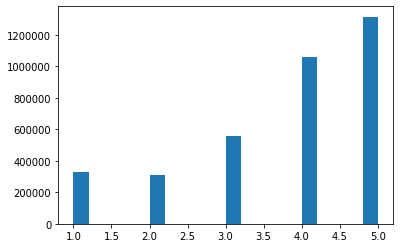

In [0]:
column_name = 'stars'
column_data = filtered_review_df.select(column_name).rdd.flatMap(lambda x: x)
column_data.cache()

bins, counts = column_data.histogram(20)

print("Count Users: {}".format(column_data.count()))
print("Count Reviews: {}".format(column_data.sum()))
print("Mean: {}".format(column_data.mean()))
print("Standard Deviation: {}".format(column_data.stdev()))

plt.hist(bins[:-1], bins=bins, weights=counts)

In [0]:
positive_review_df = filtered_review_df.filter(filtered_review_df['stars'] > 3)
positive_review_df.cache()

negative_review_df = filtered_review_df.filter(filtered_review_df['stars'] < 3)
negative_review_df = negative_review_df.sample(False, 0.15, 42)
negative_review_df.cache()

DataFrame[user_id: string, business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, yelping_since: string]

In [0]:

best_model, grid_search_results = run_model_evaluation(
    num_topic_list=[5, 10, 15, 25], 
    data=positive_review_df, 
    input_col='text'
    )


Fitting pipeline, num topics:  5


In [0]:
best_model, grid_search_results = run_model_evaluation(
    num_topic_list=[5, 10, 15, 25], 
    data=negative_review_df, 
    input_col='text'
    )

Fitting pipeline, num topics:  5
Transforming data...


In [0]:
print("Fitting pipeline")
pipeline = build_pipeline('text', 4)
model = pipeline.fit(negative_review_df)

Fitting pipeline


In [0]:
print("Transforming data...")
transform_df = model.transform(negative_review_df)
transform_df.cache()

perplexity = model.stages[-1].logPerplexity(transform_df)
print("Model perplexity: {}".format(perplexity))

Transforming data...
Model perplexity: 9.043763783442708


In [0]:
display_topics(model)

The topics described by their top-weighted terms:
+-----+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                            |termWeights                                                                                                                                                                                                                         |
+-----+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[138, 2, 18, 17, 0, 4, 49, 10, 174, 13]|[0.0027252350137657445, 0.0026498808296808512, 0.002152806307960596, 0.0

In [0]:
transform_df.show()

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+-----------+------------+------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             user_id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|       name|review_count|useful|      yelping_since|               wor

Column<b'words'>

In [0]:
from pyspark.sql import functions as F

from pyspark.sql.types import DoubleType


def _ith(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None


ith = F.udf(_ith, DoubleType())

df = transform_df.select(["text"] + [ith("topicDistribution", F.lit(i)).alias('topic_'+str(i)) for i in range(4)] )

df.sort('topic_0', ascending=False).show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------